# Hierarchical Clustering with Matrix Profile Distance Metric Example

Academic Paper: https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxtcGRpc3RpbmZvfGd4OjNjMGZjOTBmYWEzNjM0ZWY

In [1]:
import pandas as pd
import numpy as np
import matrixprofile as mp
from scipy.cluster.hierarchy import dendrogram

from matplotlib import pyplot as plt

%matplotlib inline


Bad key "backend.qt4" on line 43 in
/etc/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import urllib.request
import zipfile
import tempfile
import os

In [3]:
temp_dir = tempfile.mkdtemp()
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip'
tmp_file = os.path.join(temp_dir, 'activity_recognition.zip')
extracted_dir = os.path.join(temp_dir, 'extracted')

os.makedirs(extracted_dir, exist_ok=True)

with urllib.request.urlopen(url) as response, open(tmp_file, 'wb') as out_file:
    data = response.read() # a `bytes` object
    out_file.write(data)
    
with zipfile.ZipFile(tmp_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
    
data_dir = os.path.join(extracted_dir, 'Activity Recognition from Single Chest-Mounted Accelerometer')

In [4]:
label_description = '''
1: Working at Computer
2: Standing Up, Walking and Going updown stairs
3: Standing
4: Walking
5: Going UpDown Stairs
6: Walking and Talking with Someone
7: Talking while Standing
'''

labels = []

for line in label_description.split('\n'):
    line = line.strip()
    if line == '':
        continue
    
    tmp = line.split(':')
    num = tmp[0].strip()
    description = tmp[1].strip()
    
    labels.append({
        'label': str(num),
        'description': description
    })

labels_df = pd.DataFrame(labels)

In [5]:
labels_df

,label,description
0,1,Working at Computer
1,2,"Standing Up, Walking and Going updown stairs"
2,3,Standing
3,4,Walking
4,5,Going UpDown Stairs
5,6,Walking and Talking with Someone
6,7,Talking while Standing


In [6]:
from glob import glob

dfs = []

for csv in glob(os.path.join(data_dir, '*.csv')):
    df = pd.read_csv(csv, header=None, names=['sequence', 'x', 'y', 'z', 'label'])
    df['label'] = df['label'].astype('str')
    df['participant_id'] = csv.split('/')[-1].replace('.csv', '')
    df = pd.merge(df, labels_df, on='label')
    dfs.append(df)

df = pd.concat(dfs)

In [7]:
df

,sequence,x,y,z,label,participant_id,description
0,0.0,2287,2948,2189,1,9,Working at Computer
1,1.0,2249,2677,2046,1,9,Working at Computer
2,2.0,2270,2568,2005,1,9,Working at Computer
3,3.0,2222,2565,2003,1,9,Working at Computer
4,4.0,2235,2571,2074,1,9,Working at Computer
...,...,...,...,...,...,...,...
162495,162500.0,1926,2382,2072,7,1,Talking while Standing
162496,162500.0,1927,2388,2074,7,1,Talking while Standing
162497,162500.0,1930,2383,2074,7,1,Talking while Standing
162498,162500.0,1929,2385,2076,7,1,Talking while Standing


In [8]:
cols = ['sequence', 'x', 'label', 'participant_id', 'description']

df = df[cols].copy()

### Participant Data

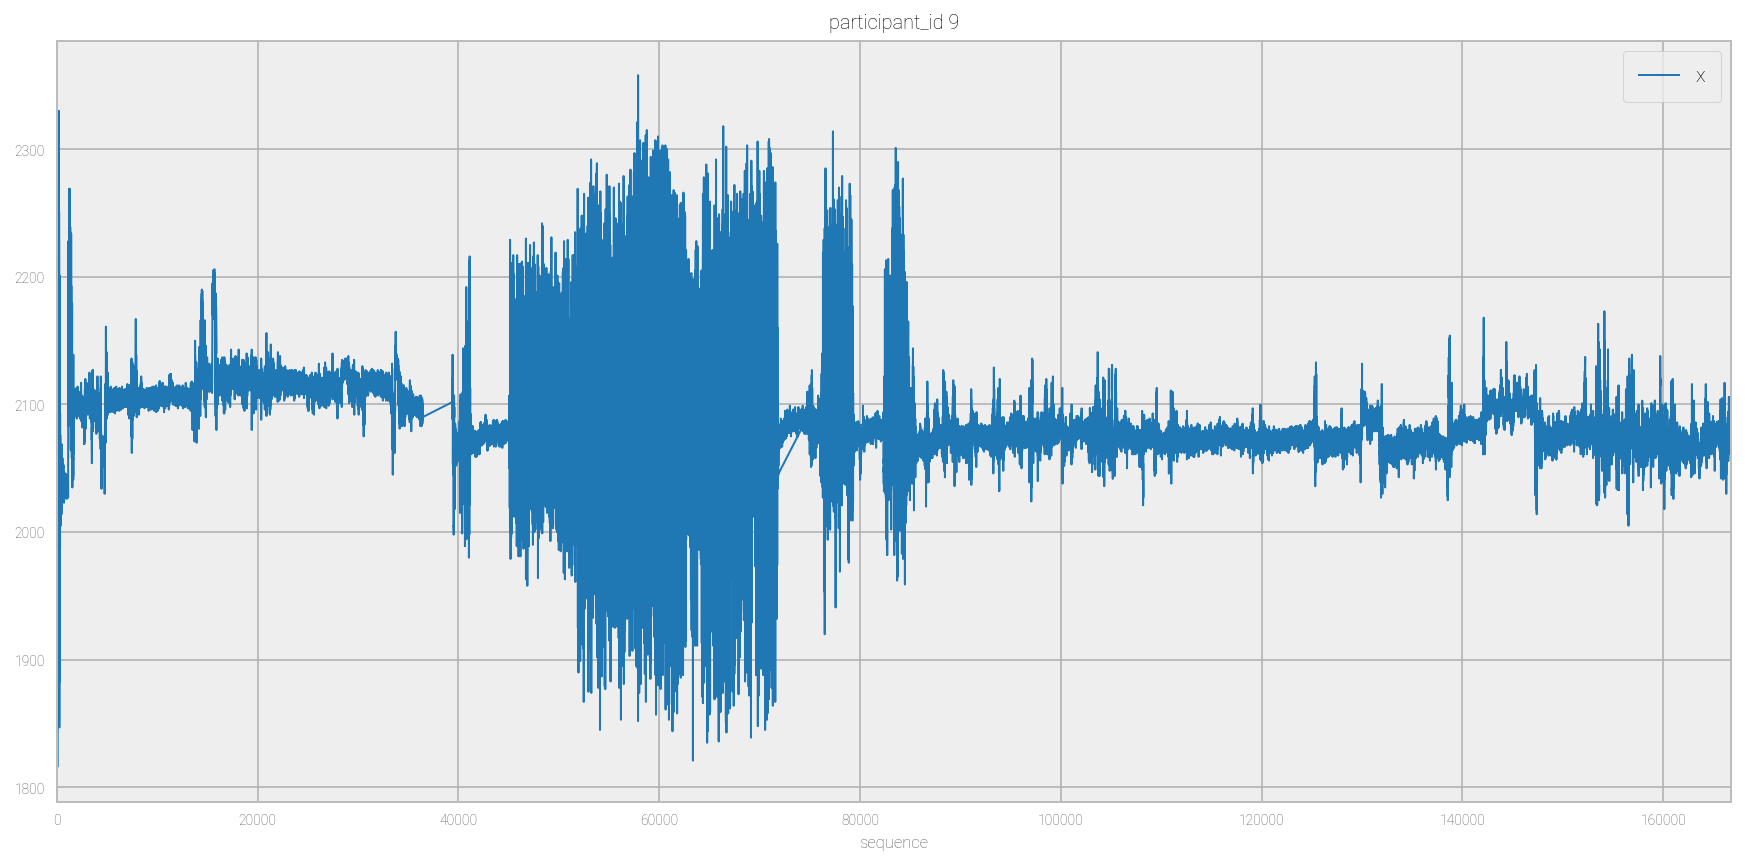

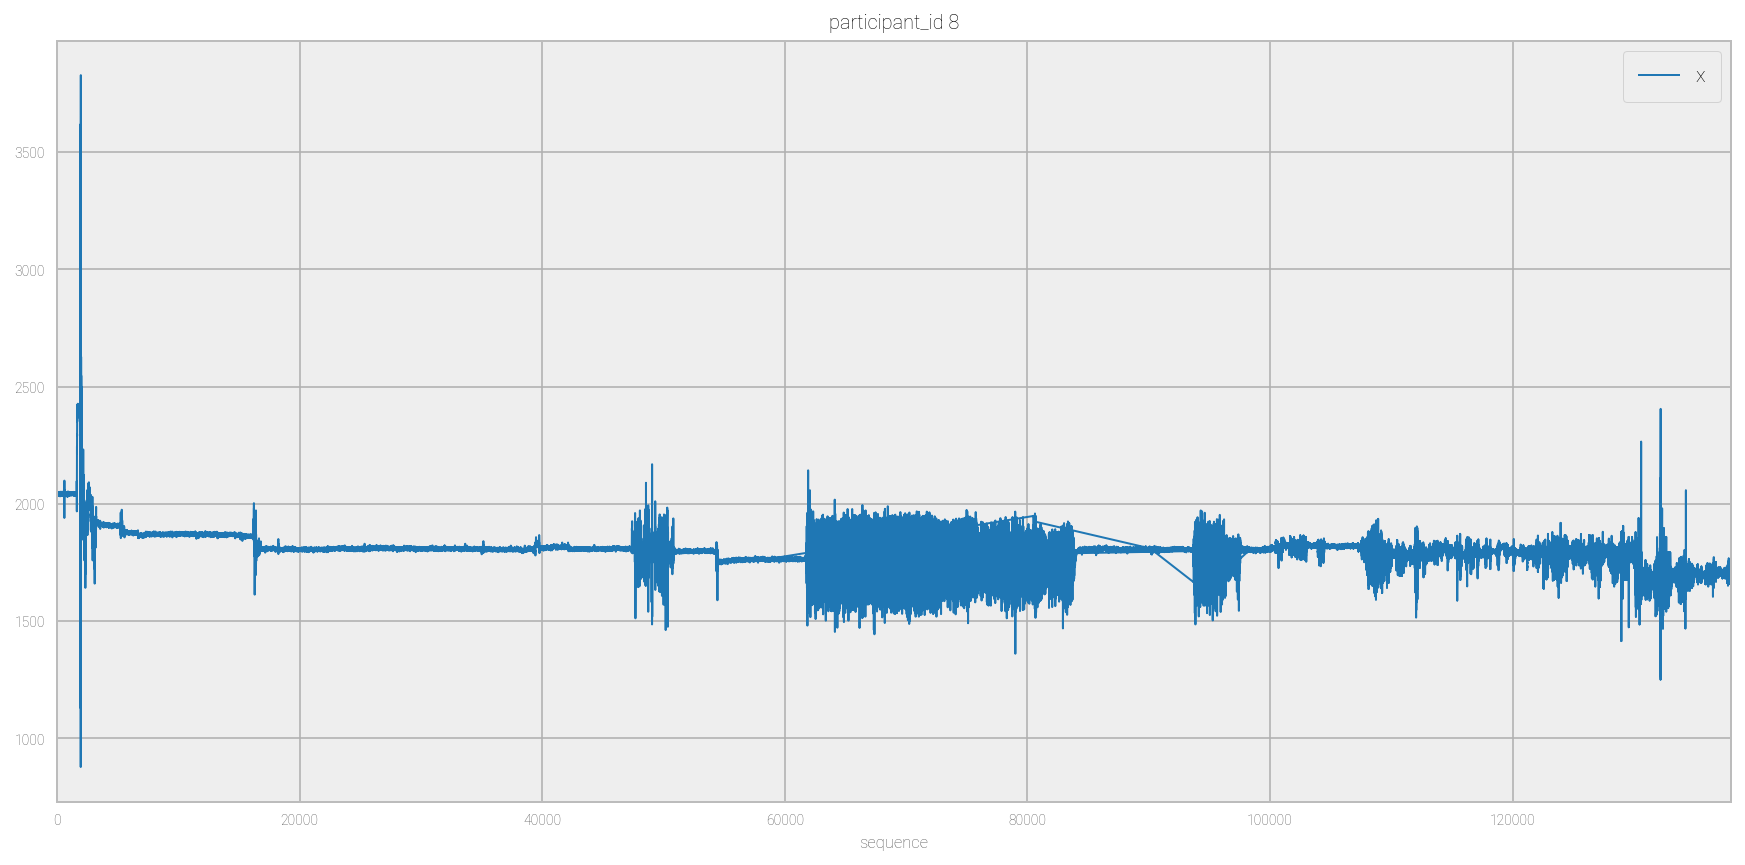

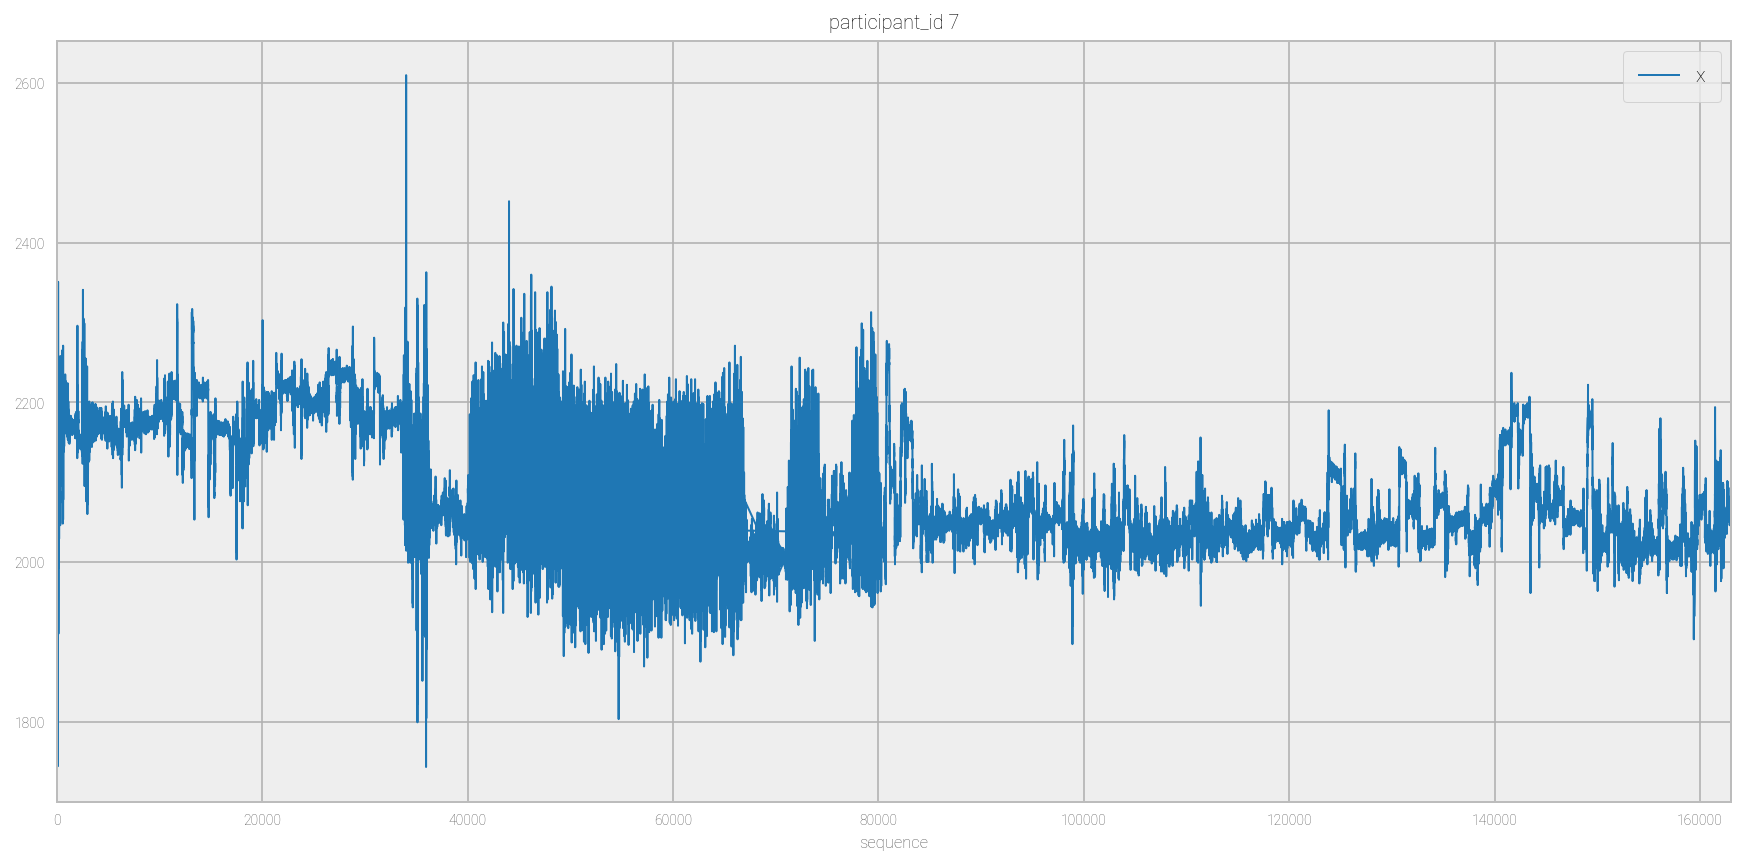

In [9]:

c = 0
for participant_id in df['participant_id'].unique():
    c += 1
    df[df['participant_id'] == participant_id].plot(x='sequence', y='x', title=f'participant_id {participant_id}', figsize=(15, 7))
    plt.show()
    
    if c >= 3:
        break

### Data Transformations

In [11]:
df = df.sort_values(['participant_id', 'sequence'])

In [12]:
series_data = []
series_labels = []
participant_labels = []

for idx, items in labels_df.iterrows():
    descr = items['description']
    label = items['label']
    
    for participant_id in df['participant_id'].unique():
        mask = (df['participant_id'] == participant_id) & (df['label'] == label)
        values = df[mask]['x'].values
        
        series_data.append(values)
        series_labels.append(descr)
        participant_labels.append(participant_id)

In [13]:
len(series_data[0]), series_labels[0], participant_labels[0]

(33677, 'Working at Computer', '1')

### Random Sampling

In [14]:
np.random.seed(9999)
random_indices = np.random.choice(np.arange(105), size=25, replace=False)

In [15]:
random_samples = []
random_labels = []

for random_index in random_indices:
    random_samples.append(series_data[random_index])
    random_labels.append(series_labels[random_index])

In [16]:
lengths = []

for ts in random_samples:
    lengths.append(len(ts))

np.min(lengths)

928

### Clustering

In [18]:
clusters = mp.discover.hierarchical_clusters(random_samples, 128, 2, n_jobs=8)


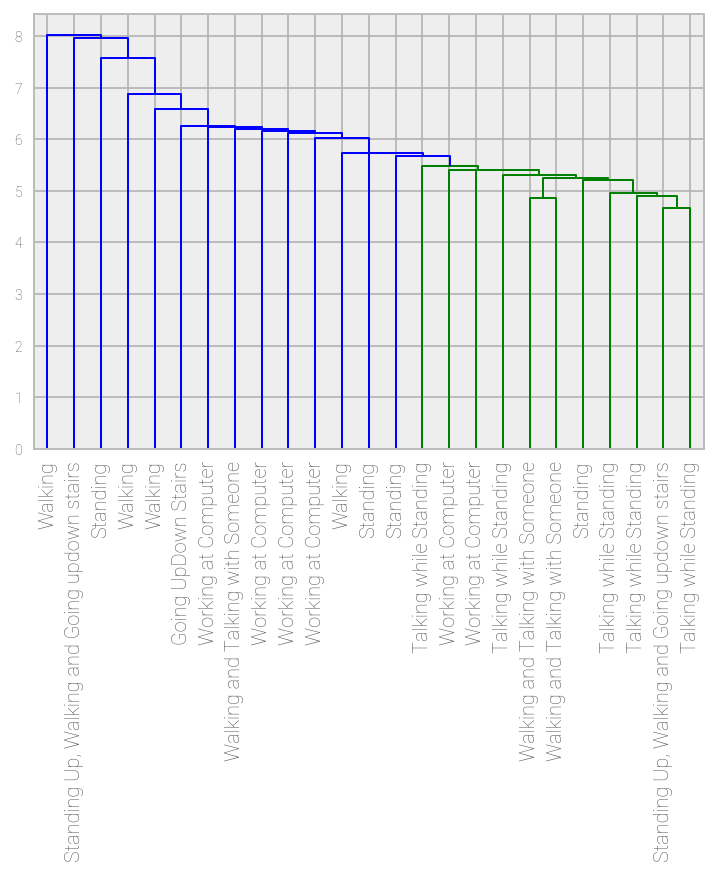

In [19]:
dendrogram(clusters['linkage_matrix'], labels=random_labels, leaf_rotation=90)
plt.show()